In [1]:
pip install adjustText

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import FactorAnalysis

import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

In [2]:
data = pd.read_csv(r'datasets/merged.csv')

In [5]:
column_rename_map = {
    'Rank_Times': 'Rank_th',
    'Country_Times': 'Country_th',
    'Overall_Times': 'Overall_th',
    'Rank_QS': 'Rank_qs',
    'Overall_QS': 'Overall_qs',
    'Country_QS': 'Country_qs'
}

data = data.rename(columns=column_rename_map)
data = data.drop(columns=['Times Name', 'QS Name'], errors='ignore')

print(data.columns.tolist())

['Rank_th', 'Name', 'Country_th', 'Year', 'Student Population', 'Students to Staff Ratio', 'International Students', 'Teaching', 'Research Environment', 'Research Quality', 'Industry Impact', 'International Outlook', 'Overall_th', 'Rank_qs', 'Institution Name', 'Country_qs', 'CS', 'CF', 'RI', 'Age', 'STA', 'AR_SCORE', 'ER_SCORE', 'FS_SCORE', 'CPF_SCORE', 'IF_SCORE', 'IS_SCORE', 'Overall_qs', 'IRN_SCORE', 'EO_SCORE', 'S_SCORE']


In [8]:
df_num = data.copy()

drop_cols = ['Name', 'Institution Name', 'Country_th', 'Country_qs', 'Year','Student Population','Students to Staff Ratio',
             'International Students','Rank_th', 'Overall_th', 'Rank_qs', 'Overall_qs','CS', 'CF', 'RI', 'Age', 'STA']
df_num = df_num.drop(columns=drop_cols)

df_num = df_num.select_dtypes(include=['number'])

 
corr_matrix = df_num.corr().abs()

 
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

 
high_corr = [(col, row, upper.loc[row, col]) 
             for col in upper.columns 
             for row in upper.index 
             if pd.notna(upper.loc[row, col]) and upper.loc[row, col] > 0.8]
 
high_corr_df = pd.DataFrame(high_corr, columns=['Feature 1', 'Feature 2', 'Correlation'])
print(high_corr_df.sort_values(by='Correlation', ascending=False))

              Feature 1              Feature 2  Correlation
0  Research Environment               Teaching     0.914432
2              ER_SCORE               AR_SCORE     0.855931
3              IF_SCORE  International Outlook     0.841386
4              EO_SCORE               AR_SCORE     0.838540
1              AR_SCORE   Research Environment     0.836661


In [7]:
# merge_map = {
#     'Teaching_Research': ['Teaching', 'Research Environment'],
#     'IS_International': ['IS_SCORE', 'International Students'],
#     'ER_AR_EO': ['ER_SCORE', 'AR_SCORE', 'EO_SCORE'],
#     'IF_InternationalOutlook': ['IF_SCORE', 'International Outlook']
# }

# df_merged = df_num.copy()

# for new_col, cols in merge_map.items():
#     if all(col in df_merged.columns for col in cols):
#         df_merged[new_col] = df_merged[cols].mean(axis=1)
#         df_merged.drop(columns=cols, inplace=True)

In [9]:
df_std = (df_num- df_num.mean()) / df_num.std()

### Implementing PCA

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num)

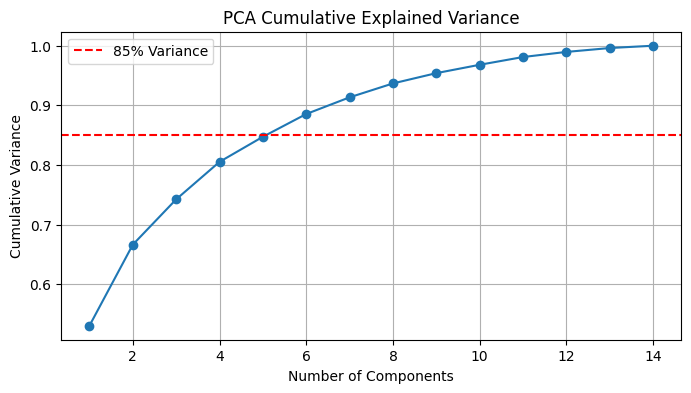

In [11]:
# PCA
pca = PCA(n_components=None)  # 先全部保留
X_pca = pca.fit(df_std)

 
explained_var = pca.explained_variance_ratio_
cum_var = explained_var.cumsum()
eigenvalues = pca.explained_variance_

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(y=0.85, color='r', linestyle='--', label='85% Variance')
plt.title('PCA Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.grid()
plt.legend()
plt.show()


In [12]:
for i, var in enumerate(explained_var, start=1):
    print(f"PC{i}: {var * 100:.2f}% variance explained")

PC1: 53.06% variance explained
PC2: 13.59% variance explained
PC3: 7.60% variance explained
PC4: 6.28% variance explained
PC5: 4.20% variance explained
PC6: 3.82% variance explained
PC7: 2.80% variance explained
PC8: 2.33% variance explained
PC9: 1.73% variance explained
PC10: 1.40% variance explained
PC11: 1.30% variance explained
PC12: 0.86% variance explained
PC13: 0.65% variance explained
PC14: 0.39% variance explained


### Factor Analysis

In [13]:
kmo_all,kmo_model=calculate_kmo(X_scaled)
kmo_model

0.8927716046914094

In [14]:
# Bartlett’s Test of Sphericity
chi2_val, p_val = calculate_bartlett_sphericity(df_std)

print(f"Bartlett's test of result:")
print(f"statistic = {chi2_val:.4f}")
print(p_val,"p-value")

Bartlett's test of result:
statistic = 67552.8735
0.0 p-value


In [15]:
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer()
fa.fit(df_std)
eigen_values, vectors = fa.get_eigenvalues()
eigen_values

array([7.42827694, 1.90279946, 1.06358921, 0.87977662, 0.58843871,
       0.53432198, 0.39153036, 0.32624801, 0.24160063, 0.19608766,
       0.18200969, 0.11991855, 0.09126459, 0.0541376 ])

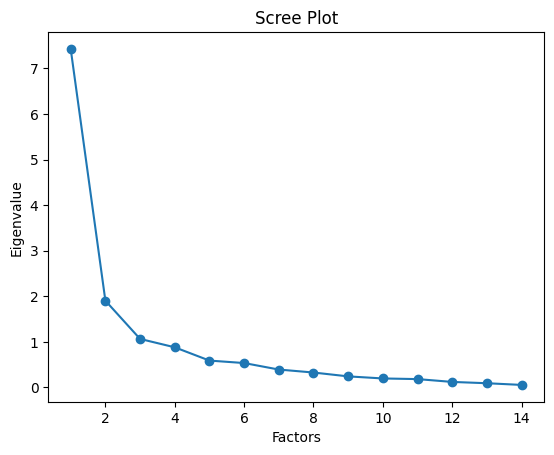

In [16]:
plt.scatter(range(1,X_scaled.shape[1]+1),eigen_values)
plt.plot(range(1,X_scaled.shape[1]+1),eigen_values)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.show()

In [17]:
fa = FactorAnalyzer(n_factors=5, rotation='varimax', method='principal')
fa.fit(df_std)

fa1 = FactorAnalyzer(n_factors=5, rotation=None, method='principal')
fa1.fit(df_std)

loadings = pd.DataFrame(
    fa.loadings_,
    index = df_std.columns,
    columns=['Factor1', 'Factor2','Factor3','Factor4','Factor5']
)
loadings1 = pd.DataFrame(
    fa1.loadings_,
    index = df_std.columns,
    columns=['Factor1', 'Factor2','Factor3','Factor4','Factor5']
)
print("Loading matrix：\n", loadings)

Loading matrix：
                         Factor1   Factor2   Factor3   Factor4   Factor5
Teaching               0.627641  0.053553  0.321018  0.448296  0.404240
Research Environment   0.647270  0.183115  0.382646  0.279751  0.466388
Research Quality       0.184661  0.359769  0.042733  0.093940  0.816802
Industry Impact        0.175270  0.033575  0.936198  0.093550  0.152843
International Outlook  0.149135  0.904198  0.036031  0.003366  0.257919
AR_SCORE               0.882025  0.160369  0.138618  0.196934  0.248515
ER_SCORE               0.884769  0.199947  0.141204  0.130766  0.024856
FS_SCORE               0.246991  0.070902  0.077274  0.922418  0.005592
CPF_SCORE              0.329931  0.215187  0.340476 -0.033687  0.678729
IF_SCORE               0.208573  0.854704  0.049215  0.010772  0.245585
IS_SCORE               0.238125  0.852831  0.033922  0.124889  0.084698
IRN_SCORE              0.615769  0.267926  0.038125 -0.060391  0.519285
EO_SCORE               0.858399  0.186263  0.05

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


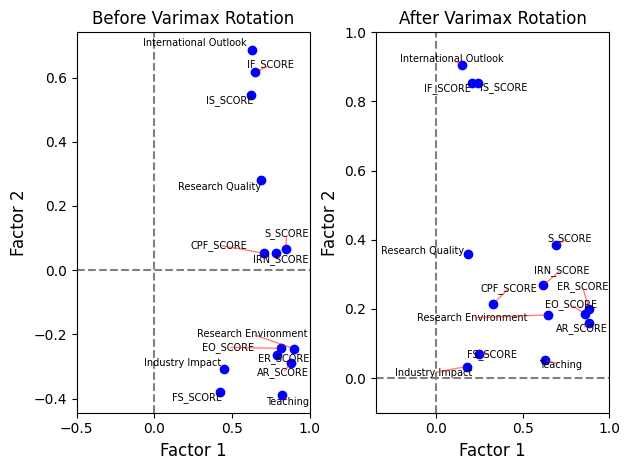

In [18]:
# Plot the difference of using rotation
plt.subplot(1, 2, 1)
plt.scatter(fa1.loadings_[:, 0], fa1.loadings_[:, 1], c='blue')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title("Before Varimax Rotation")
plt.xlabel("Factor 1",fontsize=12)
plt.ylabel("Factor 2",fontsize=12)
plt.xlim(-0.5, 1)
texts = []
for i, txt in enumerate(loadings.index):
    texts.append(plt.text(loadings1.iloc[i, 0], loadings1.iloc[i, 1], txt, ha='center',va='center',fontsize=7))
adjust_text(
    texts, 
    x=fa1.loadings_[:, 0], 
    y=fa1.loadings_[:, 1],
    arrowprops=dict(arrowstyle='-', color='red', alpha=0.5),  
    force_points=0.2,  
    force_text=0.2, 
    expand_points=(1.2, 1.2),  
    expand_text=(1.2, 1.2),
    lim=500
)

plt.subplot(1, 2, 2)
plt.scatter(fa.loadings_[:, 0], fa.loadings_[:, 1], c='blue')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title("After Varimax Rotation")
plt.xlabel("Factor 1",fontsize=12)
plt.ylabel("Factor 2",fontsize=12)
plt.xlim(-0.35, 1)
plt.ylim(-0.1, 1)

texts = []
for i, txt in enumerate(loadings.index):
    texts.append(plt.text(loadings.iloc[i, 0], loadings.iloc[i, 1], txt, ha='center',va='center',fontsize=7))

adjust_text(
    texts, 
    x=fa.loadings_[:, 1], 
    y=fa.loadings_[:, 2],
    arrowprops=dict(arrowstyle='-', color='red', alpha=0.5),  
    force_points=0.2,  
    force_text=0.2, 
    expand_points=(1.2, 1.2),  
    expand_text=(1.2, 1.2),
    lim=500
)
plt.tight_layout(w_pad=0, h_pad=2.0)
plt.show()

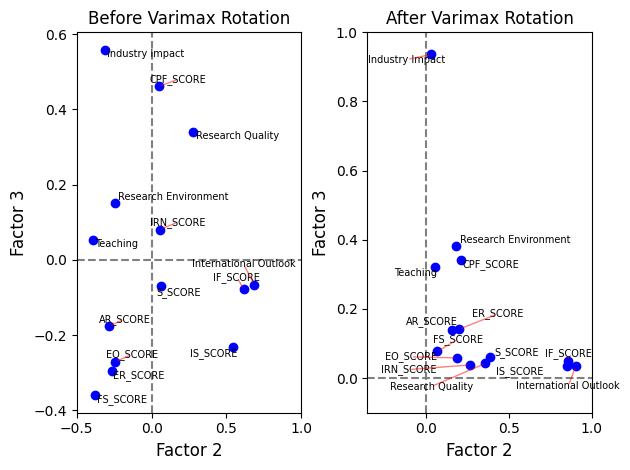

In [19]:
# Plot the difference of using rotation
plt.subplot(1, 2, 1)
plt.scatter(fa1.loadings_[:, 1], fa1.loadings_[:, 2], c='blue')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title("Before Varimax Rotation")
plt.xlabel("Factor 2",fontsize=12)
plt.ylabel("Factor 3",fontsize=12)
plt.xlim(-0.5, 1)
texts = []
for i, txt in enumerate(loadings.index):
    texts.append(plt.text(loadings1.iloc[i, 1], loadings1.iloc[i, 2], txt, ha='center',va='center',fontsize=7))
adjust_text(
    texts, 
    x=fa1.loadings_[:, 1], 
    y=fa1.loadings_[:, 2],
    arrowprops=dict(arrowstyle='-', color='red', alpha=0.5),  
    force_points=0.2,  
    force_text=0.2, 
    expand_points=(1.2, 1.2),  
    expand_text=(1.2, 1.2),
    lim=500
)

plt.subplot(1, 2, 2)
plt.scatter(fa.loadings_[:, 1], fa.loadings_[:, 2], c='blue')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title("After Varimax Rotation")
plt.xlabel("Factor 2",fontsize=12)
plt.ylabel("Factor 3",fontsize=12)
plt.xlim(-0.35, 1)
plt.ylim(-0.1, 1)

texts = []
for i, txt in enumerate(loadings.index):
    texts.append(plt.text(loadings.iloc[i, 1], loadings.iloc[i, 2], txt, ha='center',va='center',fontsize=7))

adjust_text(
    texts, 
    x=fa.loadings_[:, 1], 
    y=fa.loadings_[:, 2],
    arrowprops=dict(arrowstyle='-', color='red', alpha=0.5),  
    force_points=0.2,  
    force_text=0.2, 
    expand_points=(1.2, 1.2),  
    expand_text=(1.2, 1.2),
    lim=500
)
plt.tight_layout(w_pad=0, h_pad=2.0)
plt.show()

In [20]:
cum_explained_variance_ratio = fa.get_factor_variance()
for i, var in enumerate(cum_explained_variance_ratio[2], start=1):
    print(f"Factor{i}: {var * 100:.2f}% culmulative variance explained")

Factor1: 30.91% culmulative variance explained
Factor2: 51.00% culmulative variance explained
Factor3: 60.31% culmulative variance explained
Factor4: 69.30% culmulative variance explained
Factor5: 84.73% culmulative variance explained


In [21]:
fa.get_communalities()

array([0.86423255, 0.89468589, 0.84134894, 0.94042552, 0.90764599,
       0.92344461, 0.86045165, 0.92289006, 0.73289169, 0.83687274,
       0.80794678, 0.72571446, 0.83512771, 0.76920234])

### Calculate FA_Score

In [22]:
FA_Score = fa.fit_transform(df_std)
FA_Score = pd.DataFrame(FA_Score, columns=['FA_1', 'FA_2','FA_3','FA_4','FA_5'])
FA_Score_standardized = (FA_Score - FA_Score.min()) / (FA_Score.max() - FA_Score.min())
FA_Score_standardized

,FA_1,FA_2,FA_3,FA_4,FA_5
0,0.754524,0.655743,0.458325,0.805530,0.648901
1,0.771011,0.633535,0.356902,0.817189,0.668836
2,0.776400,0.496027,0.426651,0.776695,0.761777
3,0.595710,0.497294,0.776588,0.851807,0.719655
4,0.729532,0.635170,0.673560,0.758634,0.649856
...,...,...,...,...,...
5272,0.382739,0.274763,0.245775,0.221425,0.239533
5273,0.329656,0.257520,0.263094,0.240190,0.292702
5274,0.351666,0.216691,0.237585,0.302789,0.296449
5275,0.307835,0.232856,0.236548,0.493327,0.276080


In [23]:
loadings

,Factor1,Factor2,Factor3,Factor4,Factor5
Teaching,0.627641,0.053553,0.321018,0.448296,0.404240
Research Environment,0.647270,0.183115,0.382646,0.279751,0.466388
Research Quality,0.184661,0.359769,0.042733,0.093940,0.816802
Industry Impact,0.175270,0.033575,0.936198,0.093550,0.152843
International Outlook,0.149135,0.904198,0.036031,0.003366,0.257919
AR_SCORE,0.882025,0.160369,0.138618,0.196934,0.248515
ER_SCORE,0.884769,0.199947,0.141204,0.130766,0.024856
FS_SCORE,0.246991,0.070902,0.077274,0.922418,0.005592
CPF_SCORE,0.329931,0.215187,0.340476,-0.033687,0.678729
IF_SCORE,0.208573,0.854704,0.049215,0.010772,0.245585


In [24]:
threshold = 0.6  # 设置载荷阈值

# 自动提取每个因子对应的特征变量
yyg_features = {}
for i in range(1, loadings.shape[1] + 1):  # Factor1 ~ Factor6
    factor_col = f'Factor{i}'
    features = loadings.index[loadings[factor_col].abs() > threshold].tolist()
    yyg_features[f'yyg{i}'] = features
    print(f"yyg{i} = {features}")

yyg1 = ['Teaching', 'Research Environment', 'AR_SCORE', 'ER_SCORE', 'IRN_SCORE', 'EO_SCORE', 'S_SCORE']
yyg2 = ['International Outlook', 'IF_SCORE', 'IS_SCORE']
yyg3 = ['Industry Impact']
yyg4 = ['FS_SCORE']
yyg5 = ['Research Quality', 'CPF_SCORE']


### Calculate PCA_Score

In [25]:
col_factor1 = ['Teaching', 'Research Environment', 'AR_SCORE', 'ER_SCORE', 'IRN_SCORE', 'EO_SCORE', 'S_SCORE']
col_factor2 = ['International Outlook', 'IF_SCORE', 'IS_SCORE']
col_factor3 = ['Industry Impact']
col_factor4 = ['FS_SCORE']
col_factor5 = ['Research Quality', 'CPF_SCORE']

factor1 = df_std[col_factor1]
factor2 = df_std[col_factor2]
factor3 = df_std[col_factor3]
factor4 = df_std[col_factor4]
factor5 = df_std[col_factor5]

In [26]:
# PCA for each factor
factor_num = loadings.shape[1]
explained_variance_ratio = np.zeros(factor_num)
 

pca = PCA(n_components = 1)
pca_scores1 = pca.fit_transform(factor1)
explained_variance_ratio[0] = pca.explained_variance_ratio_[0]
pca_scores2 = pca.fit_transform(factor2)
explained_variance_ratio[1] = pca.explained_variance_ratio_[0]
pca_scores3 = pca.fit_transform(factor3)
explained_variance_ratio[2] = pca.explained_variance_ratio_[0]
pca_scores4 = pca.fit_transform(factor4)
explained_variance_ratio[3] = pca.explained_variance_ratio_[0]

pca_scores5 = pca.fit_transform(factor5)
explained_variance_ratio[4] = pca.explained_variance_ratio_[0] 
 
for i, var in enumerate(explained_variance_ratio, start=1):
    print(f"Factor {i}: {var * 100:.2f}% variance explained")


Factor 1: 75.44% variance explained
Factor 2: 84.37% variance explained
Factor 3: 100.00% variance explained
Factor 4: 100.00% variance explained
Factor 5: 79.12% variance explained


In [27]:
 
PCA_Score = np.column_stack((
    pca_scores1[:, 0],  # PC1 from factor1
    pca_scores2[:, 0],  # PC1 from factor2
    pca_scores3[:, 0],  # PC1 from factor3
    pca_scores4[:, 0],
    pca_scores5[:, 0],  # PC1 from factor3
))
 
PCA_Score = pd.DataFrame(
    PCA_Score, 
    columns=['pca_1', 'pca_2', 'pca_3', 'pca_4','pca_5']
)
 
PCA_Score_standardized = (PCA_Score - PCA_Score.min()) / (PCA_Score.max() - PCA_Score.min())
PCA_Score_standardized[PCA_Score_standardized < 1e-10] = 0

PCA_Score_standardized.head()
 

,pca_1,pca_2,pca_3,pca_4,pca_5
0,0.952297,0.967669,0.608414,1.0,0.885302
1,0.954636,0.952074,0.476807,1.0,0.885653
2,0.966629,0.806221,0.573894,1.0,0.997118
3,0.827228,0.753547,0.920173,1.0,0.997670
4,0.939758,0.928561,0.874865,1.0,1.000000


In [28]:
model_score = pd.concat([data[['Name', 'Institution Name', 'Country_th', 'Country_qs', 'Year','Rank_th','Overall_th','Rank_qs','Overall_qs']],FA_Score_standardized, PCA_Score_standardized],axis = 1)
model_score.to_csv(r'datasets\model_score_all.csv',index = False)
model_score

,Name,Institution Name,Country_th,Country_qs,Year,Rank_th,Overall_th,Rank_qs,Overall_qs,FA_1,FA_2,FA_3,FA_4,FA_5,pca_1,pca_2,pca_3,pca_4,pca_5
0,university of oxford,university of oxford,United Kingdom,United Kingdom,2018,1,94.3075,6.0,95.300000,0.754524,0.655743,0.458325,0.805530,0.648901,0.952297,0.967669,0.608414,1.000000,0.885302
1,university of cambridge,university of cambridge,United Kingdom,United Kingdom,2018,2,93.1925,5.0,95.600000,0.771011,0.633535,0.356902,0.817189,0.668836,0.954636,0.952074,0.476807,1.000000,0.885653
2,stanford university,stanford university,United States,United States,2018,3,93.0425,2.0,98.700000,0.776400,0.496027,0.426651,0.776695,0.761777,0.966629,0.806221,0.573894,1.000000,0.997118
3,california institute of technology,california institute of technology (caltech),United States,United States,2018,4,92.9825,4.0,97.700000,0.595710,0.497294,0.776588,0.851807,0.719655,0.827228,0.753547,0.920173,1.000000,0.997670
4,massachusetts institute of technology,massachusetts institute of technology (mit),United States,United States,2018,5,92.5400,1.0,100.000000,0.729532,0.635170,0.673560,0.758634,0.649856,0.939758,0.928561,0.874865,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5272,universidad peruana de ciencias aplicadas (upc),universidad peruana de ciencias aplicadas,Peru,Peru,2025,2065,13.3240,1300.0,31.012500,0.382739,0.274763,0.245775,0.221425,0.239533,0.043903,0.119645,0.101402,0.019211,0.059626
5273,universidad michoacana de san nicolâ¨â¢s de hi...,universidad michoacana de san nicolâ¨â¢s de hi...,Mexico,Mexico,2025,2073,12.9690,1401.0,49.572727,0.329656,0.257520,0.263094,0.240190,0.292702,0.014754,0.103116,0.124056,0.014156,0.048158
5274,irkutsk state university,irkutsk state university,Russian Federation,Russia,2025,2075,12.7070,1401.0,32.836667,0.351666,0.216691,0.237585,0.302789,0.296449,0.044667,0.065600,0.111111,0.131446,0.014721
5275,universidad autâ¨â®noma del estado de hidalgo,universidad autâ¨â®noma del estado de hidalgo ...,Mexico,Mexico,2025,2077,12.6425,1300.0,49.572727,0.307835,0.232856,0.236548,0.493327,0.276080,0.018954,0.054206,0.130529,0.445905,0.041457


In [29]:
model_score.describe()

,Year,Rank_th,Overall_th,Rank_qs,Overall_qs,FA_1,FA_2,FA_3,FA_4,FA_5,pca_1,pca_2,pca_3,pca_4,pca_5
count,5277.000000,5277.000000,5277.000000,5277.000000,5277.000000,5277.000000,5277.000000,5277.000000,5277.000000,5277.000000,5277.000000,5277.000000,5277.000000,5277.000000,5277.000000
mean,2022.236119,574.943718,44.870468,493.796854,41.736570,0.401928,0.439928,0.449377,0.395623,0.523393,0.316998,0.443802,0.514802,0.365371,0.490407
std,2.182439,471.736528,17.335388,372.149807,16.927060,0.157253,0.219914,0.184863,0.195341,0.180685,0.219687,0.293931,0.234524,0.305226,0.251682
min,2018.000000,1.000000,11.695000,1.000000,19.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2021.000000,199.000000,32.487500,190.000000,28.733333,0.287970,0.253247,0.305504,0.247889,0.389027,0.147935,0.177983,0.333333,0.103134,0.284488
50%,2023.000000,442.000000,43.682500,404.000000,36.100000,0.361318,0.390663,0.405990,0.342021,0.533846,0.270783,0.389548,0.435814,0.275025,0.492050
75%,2024.000000,832.000000,55.232500,725.000000,48.667393,0.492090,0.625185,0.569124,0.520841,0.661306,0.438150,0.701852,0.687163,0.591507,0.688595
max,2025.000000,2078.000000,98.477500,1401.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
